# **Creating Spark Session**

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Airline").getOrCreate()


# **Importing the .CSV file containing data for the Year 2007**
*Instruction- Please copy the file "2007.csv.bz2" into the same folder  *

In [ ]:
#reading CSV file for the year 2006 & 2007 and joining them together
df_2007 = spark.read.csv("2007.csv.bz2", header=True, inferSchema=True)
df_2006 = spark.read.csv("2006.csv.bz2", header=True, inferSchema=True)

df = df_2006.union(df_2007)

In [ ]:
df = df.sample(fraction=0.001, seed = 43)

In [ ]:
# Checking size of data frame
num_rows = df.count()
num_columns = len(df.columns)

print("Number of rows: {}".format(num_rows))
print("Number of columns: {}".format(num_columns))


Number of rows: 14691
Number of columns: 29


# **Data Inspection**
**Checking Datatypes for each column**

In [ ]:
# Reviewing data types
print(df.printSchema())

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- C

# **Data Filtering**
**Removing redundant columns and enteries**

In [ ]:
# Removing Columns
columns_to_remove = [
    'DepTime', 'ArrTime', 'FlightNum', 'TailNum', 'ActualElapsedTime',
    'CRSElapsedTime', 'AirTime', 'TaxiIn', 'TaxiOut', 'CancellationCode',
    'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
    'LateAircraftDelay', 'Cancelled', 'DepDelay'
]

# Remove specified columns from the DataFrame
data = df.select([column for column in df.columns if column not in columns_to_remove])

# Remove entries where target vector ("ArrDelay") is NA. This removes entries where flights where cancelled or diverted.
data = data.filter(data['ArrDelay'].isNotNull())


**Checking Missing Values**

In [ ]:
from pyspark.sql.functions import col, when, sum

# Finding count for missing values
null_counts = data.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in data.columns]).show()
print(null_counts)

+----+-----+----------+---------+----------+----------+-------------+--------+------+----+--------+
|Year|Month|DayofMonth|DayOfWeek|CRSDepTime|CRSArrTime|UniqueCarrier|ArrDelay|Origin|Dest|Distance|
+----+-----+----------+---------+----------+----------+-------------+--------+------+----+--------+
|   0|    0|         0|        0|         0|         0|            0|       0|     0|   0|       0|
+----+-----+----------+---------+----------+----------+-------------+--------+------+----+--------+

None


# **Data Validation**
**Identifying duplicate records**

In [ ]:
# Finding Duplicate Rows
duplicate_rows = data.exceptAll(data.dropDuplicates())

# Print number of duplicate rows
duplicate_rows.count()

# Show the duplicate rows
duplicate_rows.show()

+----+-----+----------+---------+----------+----------+-------------+--------+------+----+--------+
|Year|Month|DayofMonth|DayOfWeek|CRSDepTime|CRSArrTime|UniqueCarrier|ArrDelay|Origin|Dest|Distance|
+----+-----+----------+---------+----------+----------+-------------+--------+------+----+--------+
+----+-----+----------+---------+----------+----------+-------------+--------+------+----+--------+



**Identifying Range**

In [ ]:
# Finding Range
numeric_columns = [col_name for col_name, data_type in data.dtypes if data_type in ['int', 'double']]

# Describe numeric columns to find ranges
numeric_ranges = data.describe(numeric_columns)

# Show the ranges
numeric_ranges.show()

23/12/15 06:00:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|               Year|             Month|        DayofMonth|         DayOfWeek|        CRSDepTime|        CRSArrTime|         Distance|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|              14691|             14691|             14691|             14691|             14691|             14691|            14691|
|   mean| 2006.5065005785855| 6.540943434755973|15.626165679667825|3.9469743380300866|1329.0405690558846|1496.8650874685181|721.8620243686611|
| stddev|0.49997475734408936|3.4459961131696812| 8.812952678630191|1.9911939046846912| 461.9446035336813|477.23773744299774|565.8754805168688|
|    min|               2006|                 1|                 1|                 1|                10|                 1|               31|

In [ ]:
data.show()

+----+-----+----------+---------+----------+----------+-------------+--------+------+----+--------+
|Year|Month|DayofMonth|DayOfWeek|CRSDepTime|CRSArrTime|UniqueCarrier|ArrDelay|Origin|Dest|Distance|
+----+-----+----------+---------+----------+----------+-------------+--------+------+----+--------+
|2006|    1|        11|        3|      1800|      1912|           US|      36|   BOS| LGA|     185|
|2006|    1|        11|        3|      1540|      1825|           US|      21|   MIA| PHL|    1013|
|2006|    1|        11|        3|      1335|      1624|           US|      -4|   PHL| FLL|     992|
|2006|    1|        12|        4|       745|      1007|           US|     -18|   CLT| LAX|    2125|
|2006|    1|        12|        4|      2154|      2200|           US|      12|   PHX| LAS|     256|
|2006|    1|        13|        5|      1745|      1908|           US|      95|   DCA| BOS|     399|
|2006|    1|        13|        5|      1814|      2316|           US|      -7|   LAS| MSP|    1300|


# **Exploratory Data Analysis (EDA)**

In [ ]:
#Importing necessary libraries for plotting charts for EDA

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import avg, round, col, when, lit
import math
from matplotlib.ticker import ScalarFormatter

### **TOTAL NUMBER OF FLIGHTS BY AIRLINE**

In [ ]:
#Key-value dictionary pair for the airline code corresponding full airline name

airline_names = {
    'UA': 'United Airlines',
    'AA': 'American Airlines',
    'NW': 'Northwest Airlines',
    'EV': 'Eva Air',
    'B6': 'JetBlue Airways',
    'DL': 'Delta Air Lines',
    'OO': 'SkyWest Airlines',
    'F9': 'Frontier Airlines',
    'YV': 'Mesa Airlines',
    'US': 'US Airways',
    'AQ': 'Aloha Airlines',
    'MQ': 'Envoy Air',
    'OH': 'Comair',
    'HA': 'Hawaiian Airlines',
    'XE': 'ExpressJet Airlines',
    'AS': 'Alaska Airlines',
    'FL': 'AirTran Airways',
    'CO': 'Continental Airlines',
    'WN': 'Southwest Airlines',
    '9E': 'Endeavor Air'
}

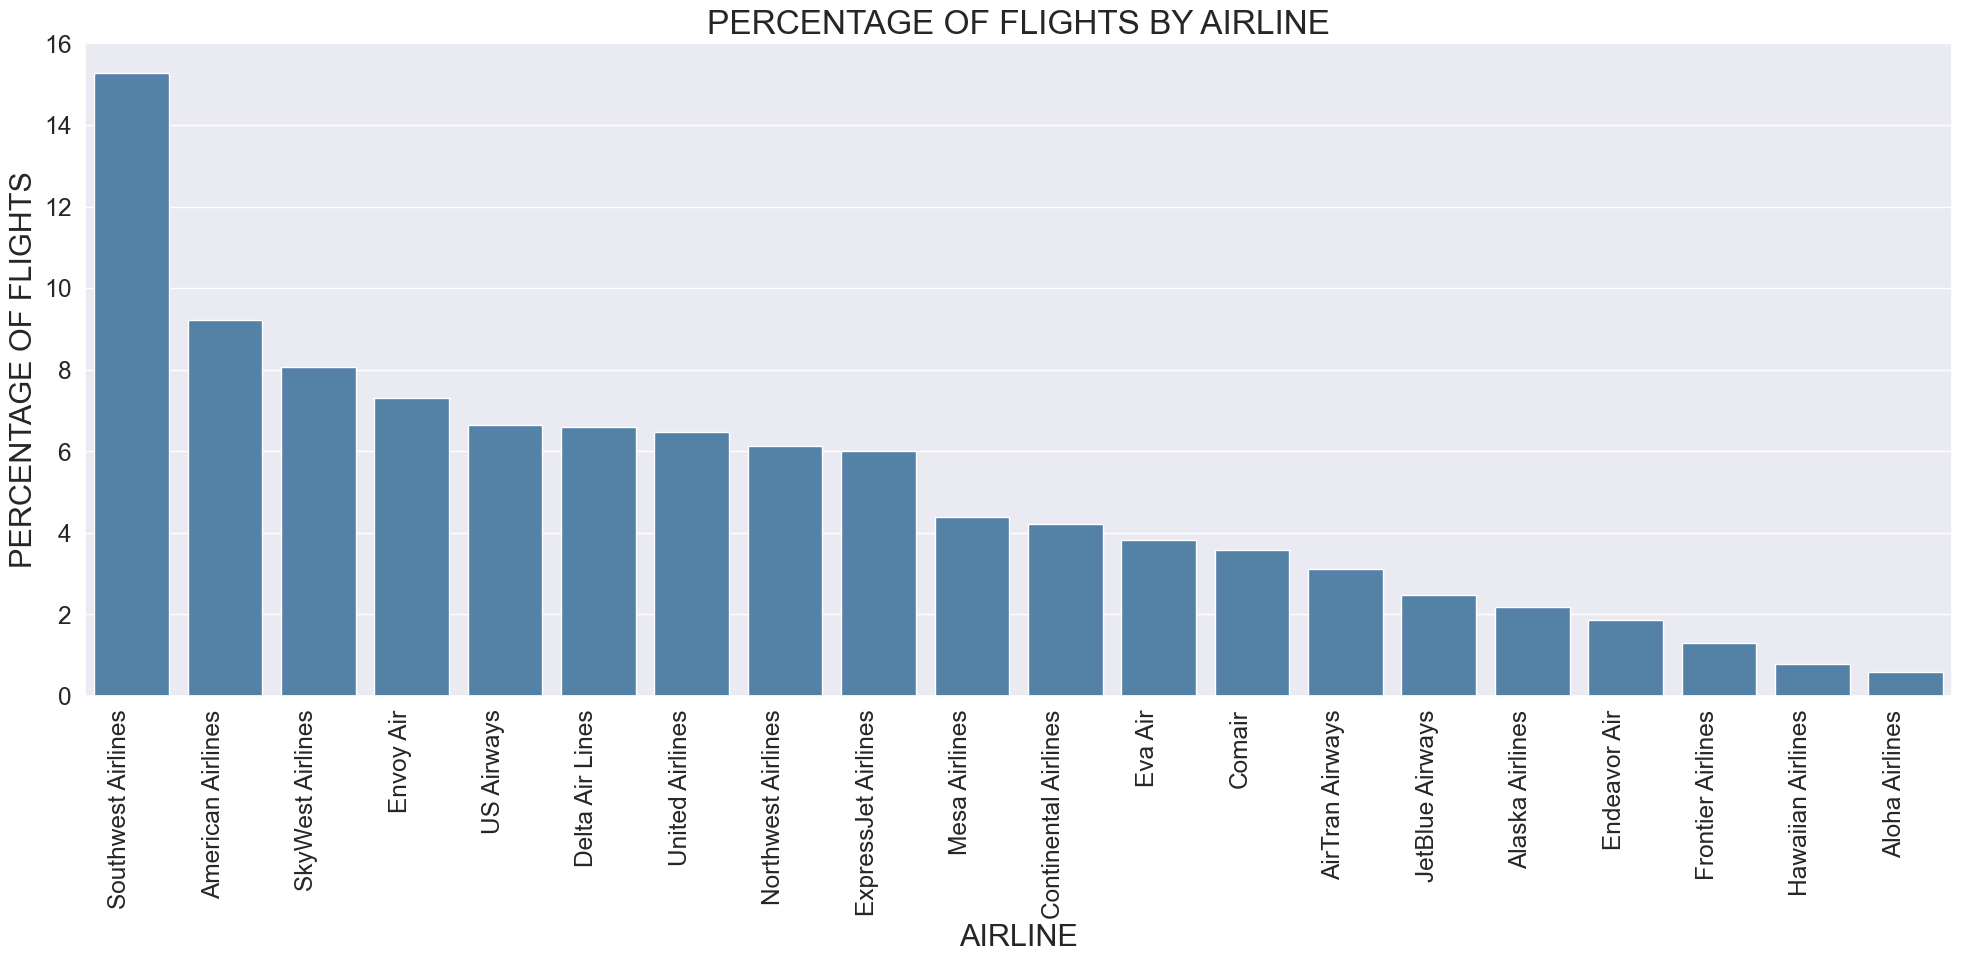

In [ ]:
# Perform the necessary Spark operations
df1_op_carrier_counts = data.groupBy("UniqueCarrier").count().orderBy("count", ascending=False).limit(20).toPandas()
df1_op_carrier_counts['UniqueCarrier'] = df1_op_carrier_counts['UniqueCarrier'].map(airline_names)
df1_op_carrier_counts = df1_op_carrier_counts.sort_values(by='count', ascending=False)

# Calculate the total number of flights
total_flights = df1_op_carrier_counts['count'].sum()

# Calculate the percentage of flights for each airline
df1_op_carrier_counts['percentage'] = (df1_op_carrier_counts['count'] / total_flights) * 100

# Plotting using Matplotlib and Seaborn
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.6)
axis = sns.barplot(x="UniqueCarrier", y="percentage", data=df1_op_carrier_counts,
                   order=df1_op_carrier_counts['UniqueCarrier'], orient="v", color='steelblue')

# Format y-axis tick labels to display percentages
axis.set_xticklabels(axis.get_xticklabels(), rotation=90, ha='right')
axis.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axis.ticklabel_format(style='plain', axis='y')

axis.set_xticklabels(axis.get_xticklabels(), rotation=90, ha='right')
plt.title('PERCENTAGE OF FLIGHTS BY AIRLINE', fontsize=24)
plt.xlabel('AIRLINE', fontsize=22)
plt.ylabel('PERCENTAGE OF FLIGHTS', fontsize=22)
plt.tight_layout()
plt.show()


### **TOP 10 DESTINATION CITIES**

In [ ]:
#Key-value dictionary pair for the city code corresponding to the full city name.

city_names = {
    'ATL': 'Atlanta',
    'ORD': 'Chicago',
    'DEN': 'Denver',
    'PHX': 'Phoenix',
    'LAX': 'Los Angeles',
    'DFW': 'Dallas/Fort Worth',
    'LAS': 'Las Vegas',
    'DTW': 'Detroit',
    'IAH': 'Houston',
    'SLC': 'Salt Lake City',
    'MSP': 'Minneapolis-Saint Paul',
    'CLT': 'Charlotte',
    'SFO': 'San Francisco',
    'MCO': 'Orlando',
    'EWR': 'Newark',
    'BWI': 'Baltimore',
    'LGA': 'New York - LaGuardia',
    'CVG': 'Cincinnati',
    'BOS': 'Boston',
    'PHL': 'Philadelphia'
}

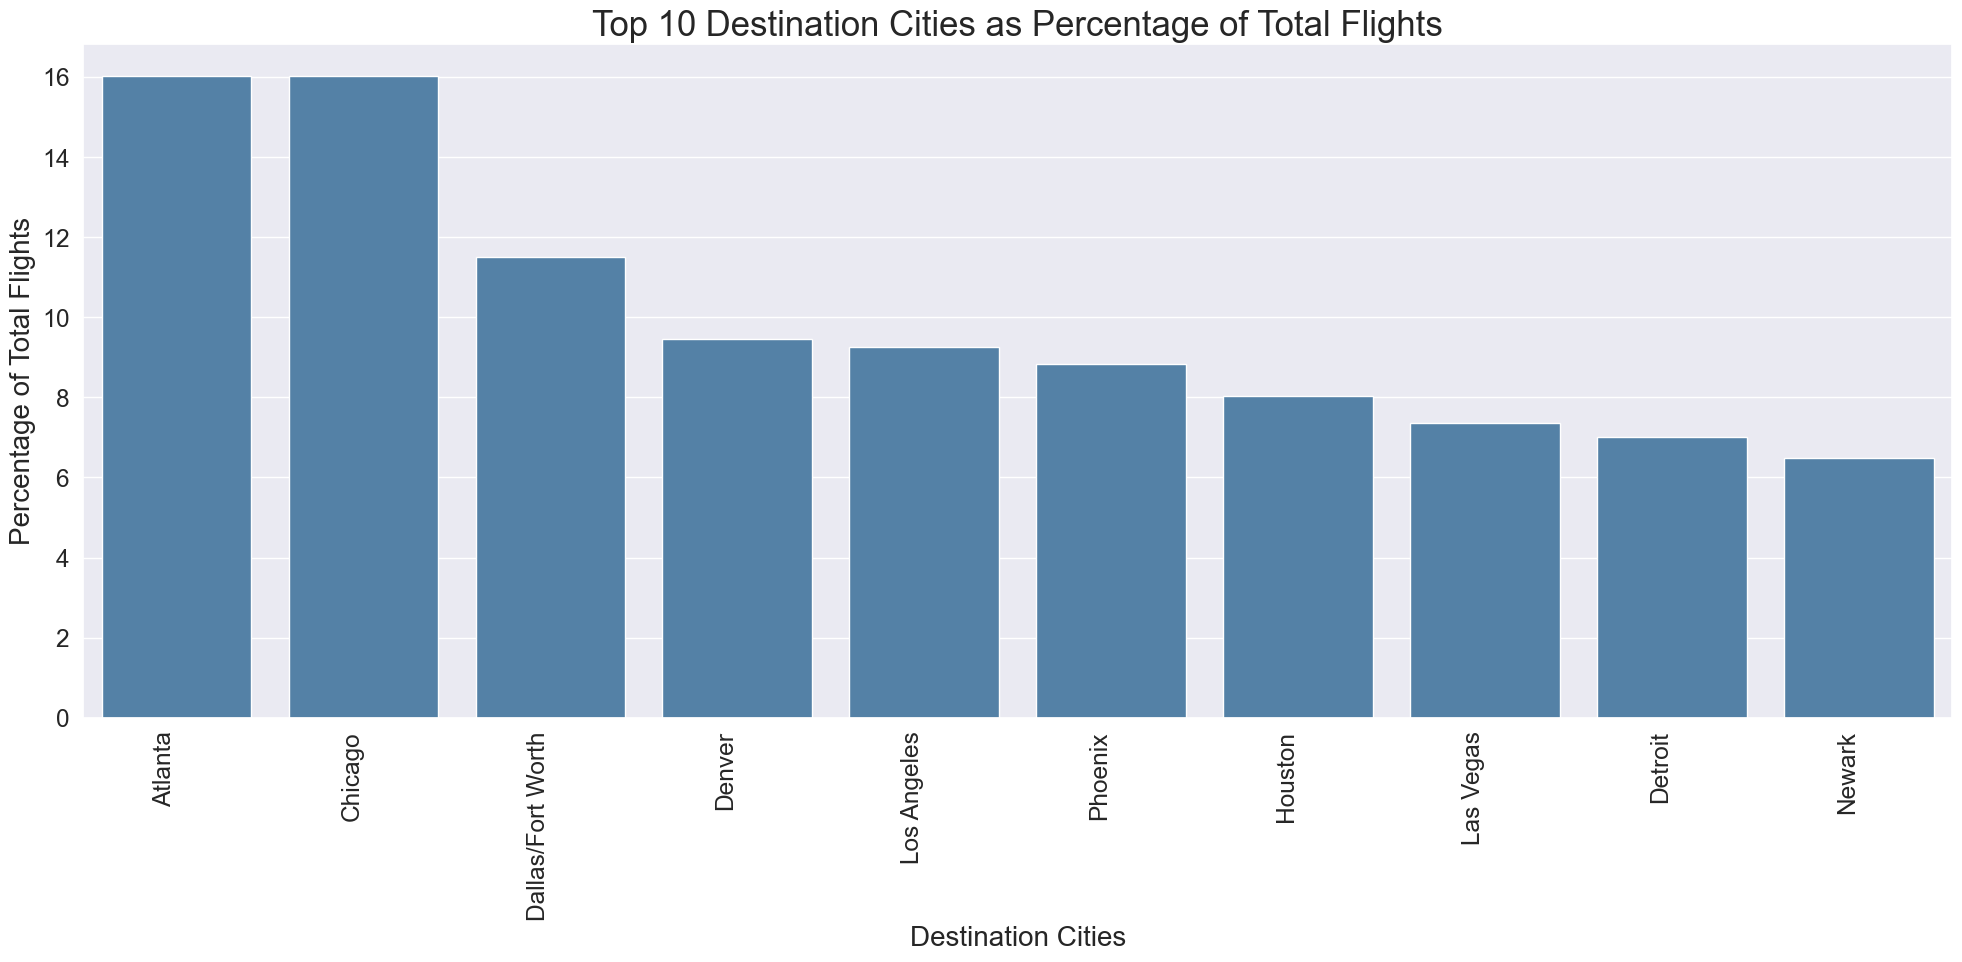

In [ ]:
# Group data by destination airport (DEST) and count the number of flights to each destination
top_destinations = data.groupBy("Dest").count().orderBy("count", ascending=False).limit(10).toPandas()

# Map destination airport codes to city names using the 'city_names' dictionary
top_destinations['Dest'] = top_destinations['Dest'].map(city_names)

# Calculate the total number of flights
total_flights = top_destinations['count'].sum()

# Calculate the percentage of flights for each destination
top_destinations['percentage'] = (top_destinations['count'] / total_flights) * 100

# Plotting using Matplotlib and Seaborn
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.6)

# Create a bar plot using Seaborn
axis = sns.barplot(x="Dest", y="percentage", data=top_destinations, order=top_destinations['Dest'], color='steelblue')

# Rotate x-axis labels for better readability
axis.set_xticklabels(axis.get_xticklabels(), rotation=90, ha='right')

# Set plot title and axis labels
plt.title('Top 10 Destination Cities as Percentage of Total Flights', fontsize=25)
plt.xlabel('Destination Cities', fontsize=20)
plt.ylabel('Percentage of Total Flights', fontsize=20)

# Format y-axis tick labels to display percentages
axis.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axis.ticklabel_format(style='plain', axis='y')

# Adjust layout for better appearance
plt.tight_layout()

# Display the plot
plt.show()



### **PERCENTAGE OF DELAYED FLIGHTS BY AIRLINE**



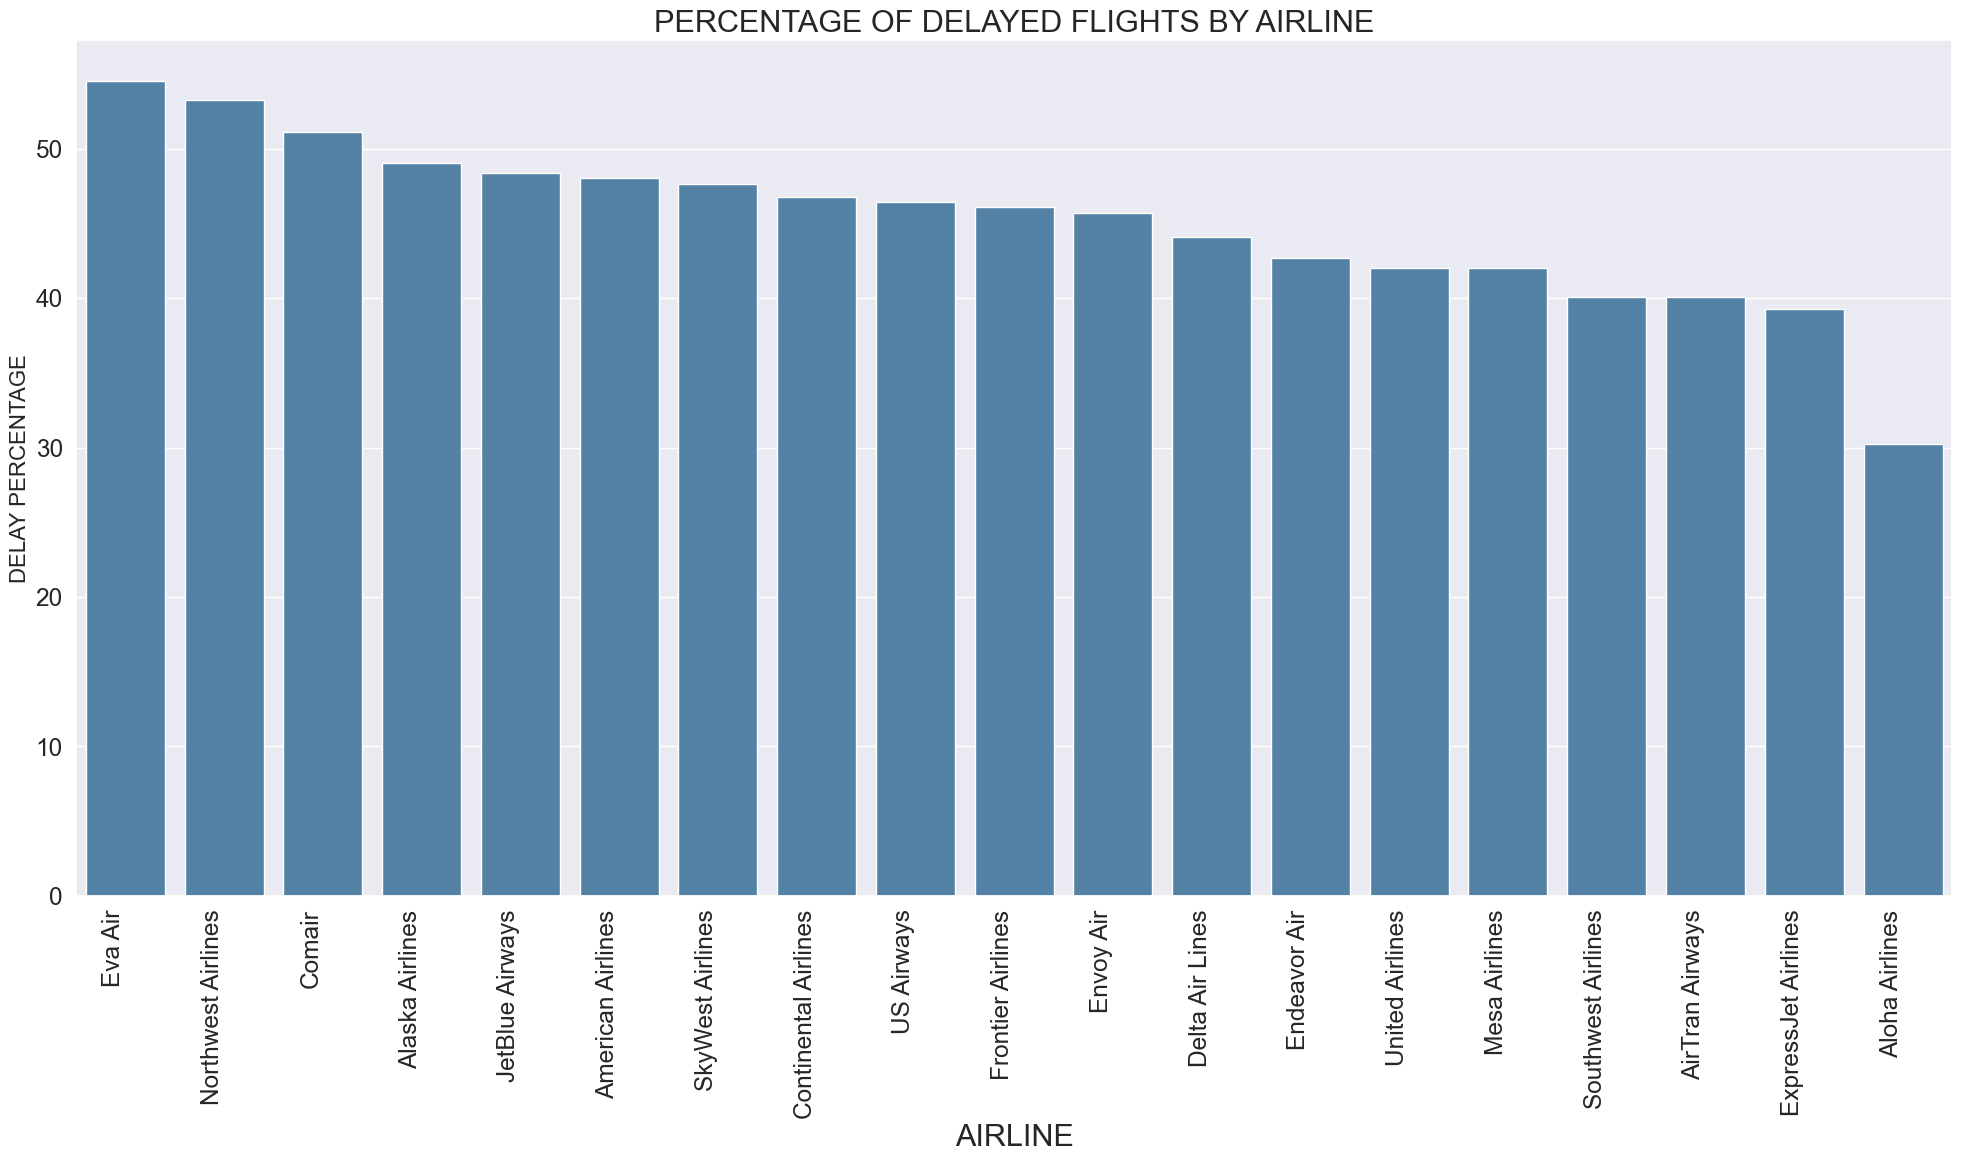

In [ ]:
# Filter delayed flights and calculate counts
delayed_flights = data.filter(data.ArrDelay > 0).groupBy("UniqueCarrier").count()

# Calculate total flights for each carrier
total_flights = data.groupBy("UniqueCarrier").count()

# Join datasets and calculate delayed percentage
delayed_percentage = (
    delayed_flights.join(total_flights, "UniqueCarrier")
    .withColumn("delayed_percentage", (delayed_flights["count"] / total_flights["count"]) * 100)
    .select("UniqueCarrier", "delayed_percentage")
    .orderBy("delayed_percentage", ascending=False)
    .limit(20)
    .toPandas()
)

# Map airline codes to names
delayed_percentage['UniqueCarrier'] = delayed_percentage['UniqueCarrier'].map(airline_names)

# Plotting using Matplotlib and Seaborn
plt.figure(figsize=(20, 12))
sns.set(font_scale=1.6)

# Use seaborn barplot directly on the Spark DataFrame
axis = sns.barplot(x="UniqueCarrier", y="delayed_percentage", data=delayed_percentage, orient="v", color='steelblue')

# Customize plot aesthetics
axis.set_xticklabels(axis.get_xticklabels(), rotation=90, ha='right')
plt.title('PERCENTAGE OF DELAYED FLIGHTS BY AIRLINE', fontsize=22)
plt.xlabel('AIRLINE', fontsize=22)
plt.ylabel('DELAY PERCENTAGE', fontsize=16)

plt.tight_layout()
plt.show()


### **AVERAGE ARRIVAL DELAY BY AIRLINE**

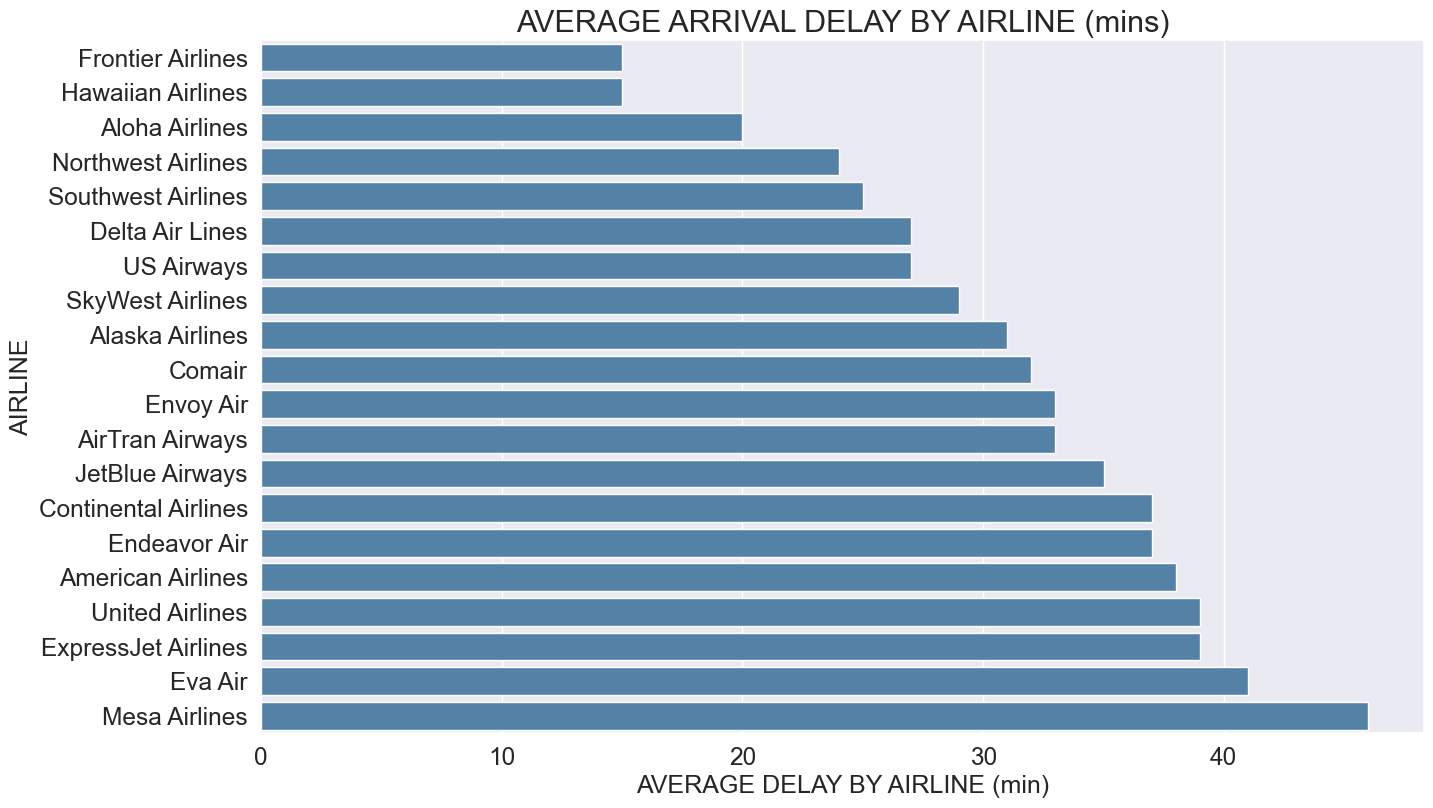

In [ ]:
# Filter data for flights with delay greater than 0
filtered_data = data.filter(data.ArrDelay > 0)

# Calculate average delays and round to whole numbers
average_delay = (
    filtered_data.groupBy("UniqueCarrier")
    .agg(round(avg("ARRDELAY")).alias("AVG_DELAY"))
    .withColumn("AirlineName", lit(None))  # Add a new column to store airline names
)

# Map airline codes to names
for airline_code, airline_name in airline_names.items():
    average_delay = average_delay.withColumn(
        "AirlineName",
        when(col("UniqueCarrier") == airline_code, airline_name).otherwise(col("AirlineName"))
    )

# Sort the data by average delay in ascending order
average_delay = average_delay.orderBy("AVG_DELAY")

# Convert Spark DataFrame to Pandas for plotting with Seaborn
average_delay_pd = average_delay.toPandas()

# Plotting using Seaborn and Matplotlib
fig = plt.figure(1, figsize=(15, 9))
sns.set(font_scale=1.6)
ax = sns.barplot(x='AVG_DELAY', y='AirlineName', data=average_delay_pd, color='steelblue')
ax.set_title('AVERAGE ARRIVAL DELAY BY AIRLINE (mins)', fontsize=22)
ax.set_xlabel('AVERAGE DELAY BY AIRLINE (min)', fontsize=18)
ax.set_ylabel('AIRLINE', fontsize=18)
plt.show()


### **WORSE & BEST MONTHS TO TRAVEL BASED ON FLIGHT DELAYS**

In [ ]:
#Key-value dictionary pair for the month number corresponding to the month.

month_dict = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

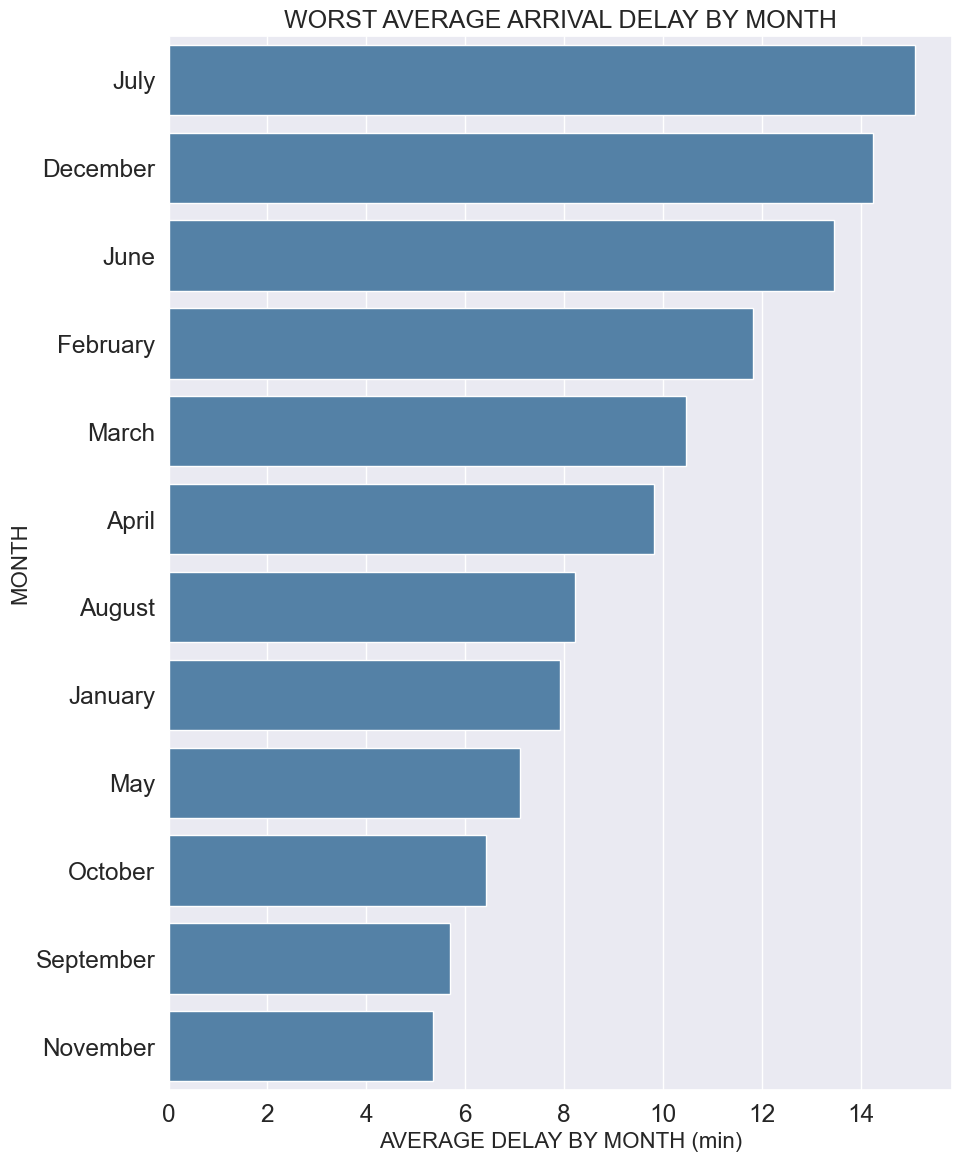

In [ ]:
# Calculate average delays by month
monthly_delay = data.groupBy("Month").agg(avg("ArrDelay").alias("AVG_DELAY"))

# Sort the data by average delay in descending order (worst months first)
worst_months = monthly_delay.orderBy("AVG_DELAY", ascending=False).toPandas()

# Map month numbers to month names using the month_dict
worst_months['Month'] = worst_months['Month'].map(month_dict)

# Plotting using Seaborn and Matplotlib for worst months
fig, ax_worst = plt.subplots(1, 1, figsize=(10, 12))

sns.barplot(x='AVG_DELAY', y='Month', data=worst_months, ax=ax_worst, color = 'steelblue')
ax_worst.set_title('WORST AVERAGE ARRIVAL DELAY BY MONTH', fontsize=18)
ax_worst.set_xlabel('AVERAGE DELAY BY MONTH (min)', fontsize=16)
ax_worst.set_ylabel('MONTH', fontsize=16)

plt.tight_layout()
plt.show()

# **Data Transformation**

In [ ]:
# import for Data Transformation
from pyspark.sql.functions import concat_ws, col, lpad, to_timestamp, when


In [ ]:
# Select the top 5 airlines for analysis
top_airlines = data.groupBy('UniqueCarrier').count().orderBy(col('count').desc()).limit(5)
top_airlines_list = [row['UniqueCarrier'] for row in top_airlines.collect()]

# Filter the DataFrame to include only the top 5 airlines
data_filtered_airlines = data.filter(data['UniqueCarrier'].isin(top_airlines_list))

# Select the top 20 destinations
top_destinations = data.groupBy('Dest').count().orderBy(col('count').desc()).limit(20)
top_destinations_list = [row['Dest'] for row in top_destinations.collect()]

# Filter the DataFrame to include only the top 20 destinations in both 'Origin' and 'Dest' columns
data = data_filtered_airlines.filter(data_filtered_airlines['Origin'].isin(top_destinations_list) & data_filtered_airlines['Dest'].isin(top_destinations_list))


In [ ]:
# Combine date-related columns into a Date column in 'yyyy-MM-dd' format
data_filtered = data.withColumn('Date',
    concat_ws('-',
              col('Year').cast('string'),
              lpad(col('Month').cast('string'), 2, '0'),
              lpad(col('DayofMonth').cast('string'), 2, '0')))

# Combine time-related columns to 'HH:mm' format for departure and arrival times
data_filtered = data_filtered.withColumn('DepTime',
    concat_ws(':',
              lpad((col('CRSDepTime') / 100).cast('int').cast('string'), 2, '0'),
              lpad((col('CRSDepTime') % 100).cast('int').cast('string'), 2, '0')))

data_filtered = data_filtered.withColumn('ArrTime',
    concat_ws(':',
              lpad((col('CRSArrTime') / 100).cast('int').cast('string'), 2, '0'),
              lpad((col('CRSArrTime') % 100).cast('int').cast('string'), 2, '0')))

# Combine date and time columns into a single datetime column
data_filtered = data_filtered.withColumn('DateTime_Dep', to_timestamp(concat_ws(' ', 'Date', 'DepTime'), 'yyyy-MM-dd HH:mm'))
data_filtered = data_filtered.withColumn('DateTime_Arr', to_timestamp(concat_ws(' ', 'Date', 'ArrTime'), 'yyyy-MM-dd HH:mm'))

# Drop intermediate columns (keeping only the DateTimeIndex columns)
processed_data = data_filtered.drop('CRSDepTime', 'CRSArrTime', 'Date', 'Year', 'DepTime', 'ArrTime', 'Month', 'DayofMonth', 'DayOfWeek')


In [ ]:
# Define the conditions and respective labels
conditions = [
    (col('ArrDelay') <= 10),
    ((col('ArrDelay') > 10) & (col('ArrDelay') <= 60)),
    ((col('ArrDelay') > 60) & (col('ArrDelay') <= 120))
]

# Define the labels corresponding to the conditions
labels = [1, 2, 3, 4]

# Apply the conditions and labels to create a new column 'label'
label_column = 'label'
processed_data = processed_data.withColumn(
    label_column,
    when(conditions[0], labels[0])
    .when(conditions[1], labels[1])
    .when(conditions[2], labels[2])
    .otherwise(labels[3])  # Default value for other cases
)

# Drop the original 'ArrDelay' column
processed_data = processed_data.drop('ArrDelay')

# **Model Building and Results**

In [ ]:
# imports for model building
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StandardScaler, OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
# Split data into train and test sets while maintaining temporal order by ordering data frame first
# We are doing this as an alternate of using TimeSeriesSplit only available using panda
processed_data = processed_data.orderBy('DateTime_Dep')
train_ratio = 0.8
test_ratio = 1 - train_ratio
train_data, test_data = processed_data.randomSplit([train_ratio, test_ratio], seed=42)

In [ ]:
# Prepare preprocessing pipeline

# Define numeric and categorical features
numeric_features = ['Distance']
categorical_features = ['UniqueCarrier', 'Origin', 'Dest']

# Assemble numerical features into a single vector
assembler = VectorAssembler(inputCols=numeric_features, outputCol='num_features')

# Scale numerical features
scaler = StandardScaler(inputCol='num_features', outputCol='scaled_features')

# Index categorical features and encode them using OneHotEncoder
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep') for col in categorical_features]
encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded") for col in categorical_features]

# Assemble all features into a single vector
input_cols = [f"{col}_encoded" for col in categorical_features] + ['scaled_features']
assembler_all = VectorAssembler(inputCols=input_cols, outputCol='features')

# Create a pipeline for preprocessing
preprocessing_stages = [assembler] + [scaler] + indexers + encoders + [assembler_all]
preprocessing_pipeline = Pipeline(stages=preprocessing_stages)


In [ ]:
# Create a Logistic Regression model for multiclass classification
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Initiate pipeline with preprocessor and model
pipeline = Pipeline(stages=[preprocessing_pipeline, lr])

# Create a ParamGrid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 1, 10]) \
    .build()

# Define an evaluator for multiclass classification
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Ideally we would use GridSearchCV with cv=timeseriesSplit to ensure temporal order is maintained
# Since GridSearchCV is not availble in PySpark, we will CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=4)

cvModel = crossval.fit(train_data)

# Get the best model from cross-validation
best_model = cvModel.bestModel

# Get the best parameters
best_params = best_model.stages[-1].extractParamMap()
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

# Get the best training score
best_train_score = cvModel.avgMetrics[cvModel.avgMetrics.index(max(cvModel.avgMetrics))]
print(f"\n\nBest Training Score: {best_train_score}")

# Get the best validation score
best_val_score = evaluator.evaluate(cvModel.bestModel.transform(train_data))
print(f"Best Validation Score: {best_val_score}")

# Make predictions on the test data using the best model
predictions = best_model.transform(test_data)
# Evaluate the model on test data
test_score = evaluator.evaluate(predictions)
print(f"Test Set Score: {test_score}")


Best Parameters:
aggregationDepth: 2
elasticNetParam: 0.0
family: auto
featuresCol: features
fitIntercept: True
labelCol: label
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
regParam: 1.0
standardization: True
threshold: 0.5
tol: 1e-06


Best Training Score: 0.6618259360539512


Best Validation Score: 0.6622950819672131


Test Set Score: 0.6467391304347826


In [ ]:
# Define your RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Define your preprocessing pipeline (preprocessing_pipeline)
pipeline = Pipeline(stages=[preprocessing_pipeline, rf])

# Create a ParamGrid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [1, 3, 5]) \
    .addGrid(rf.maxDepth, [1, 3, 5]) \
    .addGrid(rf.maxBins, [2, 3, 5]) \
    .build()

# Define an evaluator for multiclass classification
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Define CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=4,
                          seed=42)

# Run CrossValidator by setting the 'train_data'
cvModel = crossval.fit(train_data)

# Get the best model from cross-validation
best_model = cvModel.bestModel

# Get the best parameters
best_params = best_model.stages[-1].extractParamMap()
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param.name}: {value}")

# Get the best training score
best_train_score = cvModel.avgMetrics[cvModel.avgMetrics.index(max(cvModel.avgMetrics))]
print(f"\n\nBest Training Score: {best_train_score}")

# Get the best validation score
best_val_score = evaluator.evaluate(cvModel.bestModel.transform(train_data))
print(f"Best Validation Score: {best_val_score}")

# Make predictions on the test data using the best model
predictions = best_model.transform(test_data)

# Evaluate the model on test data
test_score = evaluator.evaluate(predictions)
print(f"Test Set Score: {test_score}")


23/12/15 06:22:36 WARN CacheManager: Asked to cache already cached data.
23/12/15 06:22:36 WARN CacheManager: Asked to cache already cached data.


Best Parameters:
bootstrap: True
cacheNodeIds: False
checkpointInterval: 10
featureSubsetStrategy: auto
featuresCol: features
impurity: gini
labelCol: label
leafCol: 
maxBins: 2
maxDepth: 1
maxMemoryInMB: 256
minInfoGain: 0.0
minInstancesPerNode: 1
minWeightFractionPerNode: 0.0
numTrees: 3
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 4907922549250522952
subsamplingRate: 1.0


Best Training Score: 0.6622378463299177


Best Validation Score: 0.6622950819672131


Test Set Score: 0.6467391304347826
